In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import os
import timm
import torch
import zipfile
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset

In [ ]:
# Upload API token
from google.colab import files
files.upload()

# Move token to the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c state-farm-distracted-driver-detection

Saving kaggle.json to kaggle.json
100% 4.00G/4.00G [04:08<00:00, 20.8MB/s]
100% 4.00G/4.00G [04:08<00:00, 17.3MB/s]


In [ ]:
# Change the filename to the actual zip file name
with zipfile.ZipFile("state-farm-distracted-driver-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("state-farm-distracted-driver-detection")

In [ ]:
class PATHS:
    TRAIN_IMAGES = "/content/state-farm-distracted-driver-detection/imgs/train"
    TEST_IMAGES = "/content/state-farm-distracted-driver-detection/imgs/test"

    TRAIN_METADATA = "/content/state-farm-distracted-driver-detection/driver_imgs_list.csv"

    SAVED_MODEL = "/content/model/distracted_driver_2.pth"

class CFG:
    TEST_SIZE = 0.2
    IMAGE_SIZE = (224,224)
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    BATCH_SIZE = 64
    NUM_WORKERS = 0
    LR = 0.0005
    EPOCHS = 30

In [ ]:
# Grab tabular data as df
df = pd.read_csv(PATHS.TRAIN_METADATA)
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
df['subject'].unique()[:5]

array(['p002', 'p012', 'p014', 'p015', 'p016'], dtype=object)

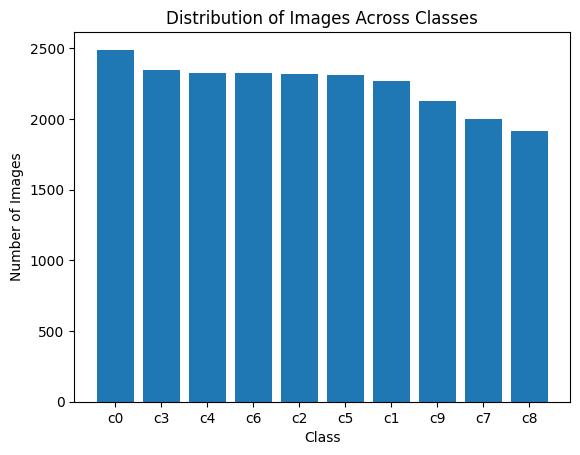

In [ ]:
# @title Distribution of Images Across Classes

import matplotlib.pyplot as plt

class_counts = df['classname'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Images')
_ = plt.title('Distribution of Images Across Classes')

In [ ]:
# Modify the classnames to be used in the NN
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['classname'])

In [ ]:
# Prepend the path to each value in the 'img' column
df['img_path'] = PATHS.TRAIN_IMAGES + '/' + df['classname'] + '/' + df['img']

# Then do it for the test set
test_path = os.listdir(PATHS.TEST_IMAGES)
jpg_files = [PATHS.TEST_IMAGES + '/' + f for f in test_path if f.lower().endswith('.jpg')]
test_df = pd.DataFrame({'img_path': jpg_files})

***Link all of the files from each class to their label***

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7CEA51770430>


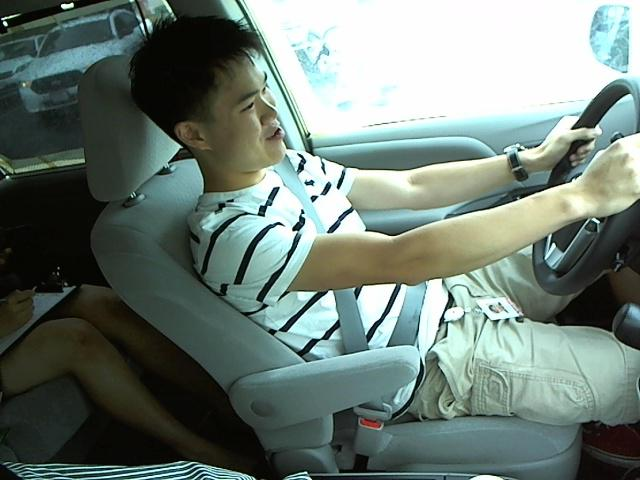

In [ ]:
# Check out the first image
image = Image.open(df['img_path'][0])
print(image)
display(image)

In [ ]:
# Split the data into test/validation randomly
#train_df, val_df = train_test_split(df, test_size=CFG.TEST_SIZE, random_state=42)

# Split the data so that the train set has different subjects to the val set
val_subjects = df['subject'].unique()[:5] # Grab 5 subjects
val_df = df[df['subject'].isin(val_subjects)]
train_df = df[~df['subject'].isin(val_subjects)]

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
class DistractedDriversDataset(Dataset):

    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])

        if self.transform:
            image = self.transform(image)

        if self.labels is None:
            return image, self.image_paths[idx].replace(PATHS.TEST_IMAGES + '/', '')
        else:
            label = self.labels[idx]
            return image, label

        label = self.labels[idx]

        return image, label

In [ ]:
# Define the transformations
train_transforms = transforms.Compose([
    transforms.Resize(CFG.IMAGE_SIZE),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(
        degrees=0,  # No rotation
        translate=(0.15, 0.15),  # Max translation as a fraction of image size
        scale=(1., 1.15)  # Scaling range from 85% (zoom out) to 115% (zoom in)
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=CFG.MEAN, std=CFG.STD)
])

test_transform = transforms.Compose([
     transforms.Resize(CFG.IMAGE_SIZE),
     transforms.ToTensor(),
     transforms.Normalize(mean=CFG.MEAN, std=CFG.STD)
])

In [ ]:
# Initialise datasets
train_dataset = DistractedDriversDataset(train_df['img_path'], train_df['target'], transform=train_transforms)
val_dataset = DistractedDriversDataset(val_df['img_path'], val_df['target'], transform=test_transform)
test_dataset = DistractedDriversDataset(test_df['img_path'], transform=test_transform)

In [ ]:
# Initialise data loaders
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS, pin_memory=True)

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet34, self).__init__()
        # Load a pre-trained ResNet-34 model
        self.base_model = timm.create_model("resnet34", pretrained=True)

        # Remove the last fully connected layer (classifier)
        self.features = nn.Sequential(
            *list(self.base_model.children())[:-2],
            nn.BatchNorm2d(512)  # Adding BatchNorm
        )

        # Output size of ResNet-34 features before the classifier layer is typically 512
        network_out_size = 512

        # Classifier that includes flattening the feature map, dropout, and linear layer for class prediction
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(p=dropout_rate),  # Apply dropout
            nn.Linear(network_out_size, 10),  # Output 10 values for multi-class classification
        )

    def forward(self, x):
        # Extract features
        x = self.features(x)
        # Classify features
        output = self.classifier(x)
        return output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Model
model = ResNet34()
model.to(device)

***Load saved weights***

In [ ]:
# Load the saved weights
#saved_weights = torch.load(PATHS.SAVED_MODEL)

# Load the weights into the model
#model.load_state_dict(saved_weights)

In [ ]:
train_losses, val_losses = [], []

# Params
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CFG.LR, weight_decay=1e-5)

# Training
for epoch in range(CFG.EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Training Loop"):
        # Move images and labels to GPU if available
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure labels are float and shaped correctly for BCEWithLogitsLoss

        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation Loop"):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure labels are float and shaped correctly for BCEWithLogitsLoss
            outputs = model(images)
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{CFG.EPOCHS} - Train Loss: {train_loss}, Validation Loss: {val_loss}")

    os.makedirs("model", exist_ok=True)
    torch.save(model.state_dict(), f"model/distracted_driver_{epoch}.pth")

Validation Loop: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]


Epoch 1/30 - Train Loss: 0.6655172331017863, Validation Loss: 0.7056723770766137


Validation Loop: 100%|██████████| 69/69 [00:30<00:00,  2.30it/s]


Epoch 2/30 - Train Loss: 0.057197624885016236, Validation Loss: 0.6976501094468869


Validation Loop: 100%|██████████| 69/69 [00:29<00:00,  2.31it/s]


Epoch 3/30 - Train Loss: 0.02816455967801938, Validation Loss: 0.701102720650144


Validation Loop: 100%|██████████| 69/69 [00:29<00:00,  2.34it/s]


Epoch 4/30 - Train Loss: 0.02508774477722817, Validation Loss: 0.8288960244165304


Training Loop:   7%|▋         | 20/282 [00:22<04:59,  1.14s/it]


KeyboardInterrupt: 

In [ ]:
import torch
from tqdm import tqdm

# Initialize counters for each number from 0 to 9
correct_counts = torch.zeros(10, device='cuda:0')
incorrect_counts = torch.zeros(10, device='cuda:0')

# No gradient calculation needed
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validation Loop"):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure labels are float and shaped correctly for BCEWithLogitsLoss
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.unsqueeze(1)

        # Convert labels to long type to match the data type of predicted
        labels = labels.long()

        # Iterate through each possible number (0-9)
        for i in range(10):
            # Count correct predictions for the current number
            correct_counts[i] += ((predicted == i) & (labels == i)).sum().item()

            # Count incorrect predictions for the current number
            incorrect_counts[i] += ((predicted == i) & (labels != i)).sum().item()

Validation Loop: 100%|██████████| 69/69 [00:33<00:00,  2.07it/s]


In [ ]:
# Print the counts
for i in range(10):
    correct = correct_counts[i]
    incorrect = incorrect_counts[i]
    total = correct + incorrect
    print(f'Number {i} - Correct: {correct}, Incorrect: {incorrect}, {(100 / total) * correct}%')
sum_correct = sum(correct_counts)
sum_incorrect_counts = sum(incorrect_counts)
total = sum_correct + sum_incorrect_counts
print(f'Total Correct: {sum(correct_counts)}, Incorrect: {(100 / total) * sum_correct}%')

Number 0 - Correct: 377.0, Incorrect: 112.0, 77.09611511230469%
Number 1 - Correct: 385.0, Incorrect: 4.0, 98.97172546386719%
Number 2 - Correct: 451.0, Incorrect: 3.0, 99.33920288085938%
Number 3 - Correct: 463.0, Incorrect: 28.0, 94.29735565185547%
Number 4 - Correct: 393.0, Incorrect: 23.0, 94.47115325927734%
Number 5 - Correct: 475.0, Incorrect: 19.0, 96.15385437011719%
Number 6 - Correct: 450.0, Incorrect: 110.0, 80.35714721679688%
Number 7 - Correct: 363.0, Incorrect: 3.0, 99.1803207397461%
Number 8 - Correct: 177.0, Incorrect: 140.0, 55.83596420288086%
Number 9 - Correct: 177.0, Incorrect: 224.0, 44.139652252197266%
Total Correct: 3711.0, Incorrect: 84.78409576416016%


In [ ]:
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f} %')

In [ ]:
# Generate test predictions
model.eval()
test_predictions = []
image_names = []

with torch.no_grad():
    for images, image_paths in tqdm(test_loader, desc="Prediction Loop"):
        image_names.extend(image_paths)
        images = images.to(device)
        outputs = model(images)
        preds = torch.softmax(outputs, dim=1)  # Use softmax for multi-class probabilities
        test_predictions.extend(preds.cpu().numpy())

test_predictions = np.array(test_predictions)

In [ ]:
# Convert image names to a column array
image_names_array = np.array(image_names).reshape(-1, 1)

# Concatenate image names array with the original ndarray
test_predictions = np.hstack((image_names_array, test_predictions))

# Header to add to the CSV file
header = 'img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9'

# Save the predictions to a CSV file
np.savetxt('submission.csv', test_predictions, delimiter=',', fmt='%s', header=header, comments='')

In [ ]:
# Save the predictions to a CSV file
np.savetxt('submission.csv', test_predictions, delimiter=',', fmt='%s', header=header, comments='')

In [ ]:
!kaggle competitions submit -c state-farm-distracted-driver-detection -f submission.csv -m "Attempt #1"